CS4001/4042 Assignment 1
---
Part A, Q1 (15 marks)
---

>Design a feedforward deep neural network (DNN) which consists of **three** hidden layers of 128 neurons each with ReLU activation function, and an output layer with sigmoid activation function. Apply dropout of probability **0.2** to each of the hidden layers. 

In [46]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import time
from torch import nn
from torch.utils.data import Dataset, TensorDataset
from torch.utils.data import DataLoader

from scipy.io import wavfile as wav

from sklearn import preprocessing
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix
from sklearn.preprocessing import StandardScaler

from common_utils import set_seed

# setting seed
set_seed()

Define the model class.

In [49]:
import torch.nn as nn
class MLPModel(nn.Module):
    def __init__(self, input_dim):
        super(MLPModel, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.2),

            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Dropout(0.2),

            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Dropout(0.2),

            nn.Linear(128, 1),  # Single output neuron for binary classification
            nn.Sigmoid()        # Sigmoid activation for probabilities
        )

    def forward(self, x):
        return self.layers(x)

> Divide the dataset into a 70:30 ratio for training and testing. Use **appropriate** scaling of input features. We solely assume that there are only two datasets here: training & test.

Split the dataset and do preprocessing. You can use the split_dataset and preprocess_dataset provided for you.

In [271]:
from common_utils import split_dataset, preprocess_dataset

df = pd.read_csv("audio_gtzan.csv")

# Extract label from filename
df['label'] = df['filename'].apply(lambda x: x.split('.')[0])  

# Dropping columns that are not features
columns_to_drop = ["filename", "label"]

# Split into training and testing (70:30)
df_train, y_train, df_test, y_test = split_dataset(
    df,
    columns_to_drop=columns_to_drop,
    test_size=0.30,
    random_state=42
)

# Scale the training and testing features using StandardScaler
X_train_scaled, X_test_scaled, scaler = preprocess_dataset(df_train, df_test)

X_train_scaled.shape

(1400, 57)

> Use the training dataset to train the model for 100 epochs. Use a mini-batch gradient descent with **‘Adam’** optimizer with learning rate of **0.001**, and **batch size = 128**. Implement early stopping with patience of **3**.

1. Define a Pytorch Dataset and Dataloaders.  

In [290]:
from torch.utils.data import TensorDataset

# Convert scaled NumPy arrays to PyTorch tensors
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)  # y_train is from split_dataset
X_test_tensor  = torch.tensor(X_test_scaled,  dtype=torch.float32)
y_test_tensor  = torch.tensor(y_test,  dtype=torch.float32)

# Create TensorDataset objects
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset  = TensorDataset(X_test_tensor,  y_test_tensor)

# Create DataLoaders
batch_size = 128  # per assignment spec
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader  = DataLoader(test_dataset,  batch_size=batch_size, shuffle=False)

2. Next, define the model, optimizer and loss function.

In [293]:
import torch.nn as nn

# Create an instance of the model
input_dim = X_train_scaled.shape[1]  
model = MLPModel(input_dim=input_dim)

# Binary cross-entropy loss for a single sigmoid output
loss_fn = nn.BCELoss()

# Adam optimizer with learning rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


3. Train model for 100 epochs. Record down train and test accuracies. Implement early stopping.

In [296]:
from common_utils import EarlyStopper

num_epochs = 100
early_stopper = EarlyStopper(patience=3, min_delta=0.0)

train_losses, test_losses = [], []
train_accuracies, test_accuracies = [], []

In [298]:
for epoch in range(num_epochs):
    # ----- TRAINING -----
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch).squeeze()  # shape [batch_size]
        
        # Compute loss
        loss = loss_fn(outputs, y_batch)
        
        # Backprop and update
        loss.backward()
        optimizer.step()
        
        # Accumulate training loss
        running_loss += loss.item() * X_batch.size(0)
        
        # Convert outputs to 0/1 predictions
        preds = (outputs >= 0.5).float()
        correct_train += (preds == y_batch).sum().item()
        total_train += y_batch.size(0)

    epoch_train_loss = running_loss / len(train_loader.dataset)
    epoch_train_acc  = correct_train / total_train

    # ----- VALIDATION/TEST -----
    model.eval()
    running_loss_test = 0.0
    correct_test = 0
    total_test = 0

    with torch.no_grad():
        for X_batch_test, y_batch_test in test_loader:
            outputs_test = model(X_batch_test).squeeze()
            loss_test = loss_fn(outputs_test, y_batch_test)
            running_loss_test += loss_test.item() * X_batch_test.size(0)
            
            preds_test = (outputs_test >= 0.5).float()
            correct_test += (preds_test == y_batch_test).sum().item()
            total_test += y_batch_test.size(0)

    epoch_test_loss = running_loss_test / len(test_loader.dataset)
    epoch_test_acc  = correct_test / total_test

    # Record metrics
    train_losses.append(epoch_train_loss)
    test_losses.append(epoch_test_loss)
    train_accuracies.append(epoch_train_acc)
    test_accuracies.append(epoch_test_acc)

    print(f"Epoch [{epoch+1}/{num_epochs}] "
          f"Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_acc:.4f}, "
          f"Test Loss: {epoch_test_loss:.4f}, Test Acc: {epoch_test_acc:.4f}")

    # Early stopping on test loss
    if early_stopper.early_stop(epoch_test_loss):
        print("Early stopping triggered.")
        break

Epoch [1/100] Train Loss: 0.6154, Train Acc: 0.7993, Test Loss: 0.4932, Test Acc: 0.8533
Epoch [2/100] Train Loss: 0.4022, Train Acc: 0.8500, Test Loss: 0.3427, Test Acc: 0.8667
Epoch [3/100] Train Loss: 0.2796, Train Acc: 0.8871, Test Loss: 0.2373, Test Acc: 0.9017
Epoch [4/100] Train Loss: 0.1787, Train Acc: 0.9293, Test Loss: 0.1805, Test Acc: 0.9167
Epoch [5/100] Train Loss: 0.1277, Train Acc: 0.9514, Test Loss: 0.1654, Test Acc: 0.9283
Epoch [6/100] Train Loss: 0.1088, Train Acc: 0.9621, Test Loss: 0.1609, Test Acc: 0.9500
Epoch [7/100] Train Loss: 0.0862, Train Acc: 0.9693, Test Loss: 0.1370, Test Acc: 0.9500
Epoch [8/100] Train Loss: 0.0572, Train Acc: 0.9814, Test Loss: 0.1321, Test Acc: 0.9533
Epoch [9/100] Train Loss: 0.0526, Train Acc: 0.9850, Test Loss: 0.1271, Test Acc: 0.9583
Epoch [10/100] Train Loss: 0.0458, Train Acc: 0.9850, Test Loss: 0.1275, Test Acc: 0.9583
Epoch [11/100] Train Loss: 0.0349, Train Acc: 0.9907, Test Loss: 0.1159, Test Acc: 0.9583
Epoch [12/100] Trai

> Plot train and test accuracies and losses on training and test data against training epochs and comment on the line plots.

In [301]:
epochs_ran = range(1, len(train_losses) + 1)

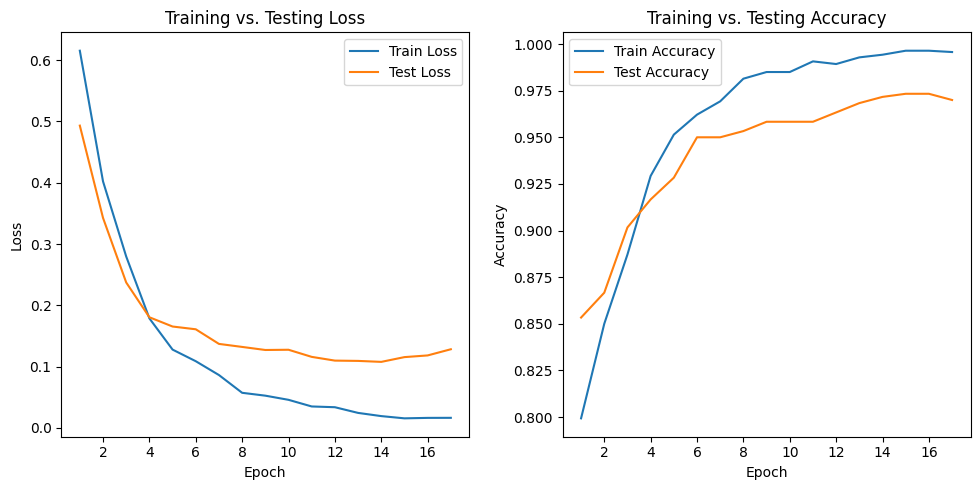

In [303]:
plt.figure(figsize=(10,5))

# Plot losses
plt.subplot(1,2,1)
plt.plot(epochs_ran, train_losses, label='Train Loss')
plt.plot(epochs_ran, test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs. Testing Loss')
plt.legend()

# Plot accuracies
plt.subplot(1,2,2)
plt.plot(epochs_ran, train_accuracies, label='Train Accuracy')
plt.plot(epochs_ran, test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training vs. Testing Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

#### Comments:
The training loss decreases steadily toward zero, while the test loss flattens and begins to rise slightly, suggesting the onset of overfitting. Meanwhile, the training accuracy climbs close to 100%, and the test accuracy also improves but remains a few points lower. This gap indicates that the model is memorizing the training set more than generalizing to unseen data. Nonetheless, both curves show that the model is learning effectively overall. The results demonstrate strong performance with some room to improve generalization.

<Comments/>
<The training and testing losses both drop close to zero by around the eighth epoch, while accuracy on both sets climbs quickly to nearly 100%. This shows that the model learns the task effectively and generalizes well, since the training and testing curves closely match each other. There are no clear signs of overfitting, as we don’t see a growing gap between the training and testing performance. Overall, the model achieves near‐perfect classification, indicating that it can accurately distinguish the two classes in the dataset.\>

Part A, Q2 (10 marks)
---

In this question, we will determine the optimal batch size for mini-batch gradient descent. Find the optimal batch size for mini-batch gradient descent by training the neural network and evaluating the performances for different batch sizes. Note: Use 5-fold cross-validation on training partition to perform hyperparameter selection. You will have to reconsider the scaling of the dataset during the 5-fold cross validation.

To reduce repeated code, you may need to place the network (MLP defined in QA1) in a separate file called **common_utils.py**. Import it here for Q2. You will not be repenalised for any error in QA1 here as the code in QA1 will not be remarked. The following code cell will not be marked.

In [306]:
from common_utils import MLPModel
import time

> Plot mean cross-validation accuracies on the final epoch for different batch sizes as a scatter plot. Limit search space to batch sizes {32, 64, 128, 256}. Next, create a table of time taken to train the network on the last epoch against different batch sizes. Finally, select the optimal batch size and state a reason for your selection. This might take a while to run, so plan your time carefully.

1. Define different folds for different batch sizes to get a dictionary of training and validation datasets. Preprocess your datasets accordingly. Please use the following name conventions:
    - X_train_scaled_dict[batch_size] is a list of the preprocessed training matrix for the different folds. 
    - X_val_scaled_dict[batch_size] is a list of the processed validation matrix for the different folds. 
    - y_train_dict[batch_size] and y_val_dict[batch_size] is a list of labels for the different folds.

In [308]:
batch_sizes = [32, 64, 128, 256]

def cross_val_score_for_batch_size(X, y, batch_size, n_splits=5, epochs=10, lr=0.001):
    """
    Performs K-fold cross-validation with the given batch_size.
    Returns the average accuracy across folds.
    """
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    fold_accuracies = []

    for train_idx, val_idx in kf.split(X):
        # Split into train/val for this fold
        X_train_fold, X_val_fold = X[train_idx], X[val_idx]
        y_train_fold, y_val_fold = y[train_idx], y[val_idx]

        # Re-scale the data within each fold
        scaler = StandardScaler()
        X_train_fold = scaler.fit_transform(X_train_fold)
        X_val_fold   = scaler.transform(X_val_fold)

        # Convert to PyTorch tensors
        X_train_tensor = torch.tensor(X_train_fold, dtype=torch.float32)
        y_train_tensor = torch.tensor(y_train_fold, dtype=torch.float32)
        X_val_tensor   = torch.tensor(X_val_fold,   dtype=torch.float32)
        y_val_tensor   = torch.tensor(y_val_fold,   dtype=torch.float32)

        # Create DataLoaders
        train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
        val_dataset   = TensorDataset(X_val_tensor,   y_val_tensor)
        train_loader  = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        val_loader    = DataLoader(val_dataset,   batch_size=batch_size, shuffle=False)

        # Initialize a fresh model for each fold
        input_dim = X.shape[1]
        model = MLPModel(input_dim)  # from Q1
        criterion = nn.BCELoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)

        # Train for a set number of epochs
        for epoch in range(epochs):
            model.train()
            for Xb, yb in train_loader:
                optimizer.zero_grad()
                outputs = model(Xb).squeeze()
                loss = criterion(outputs, yb)
                loss.backward()
                optimizer.step()

        # Evaluate on the validation fold
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for Xb_val, yb_val in val_loader:
                outputs_val = model(Xb_val).squeeze()
                preds = (outputs_val >= 0.5).float()
                correct += (preds == yb_val).sum().item()
                total   += yb_val.size(0)

        fold_acc = correct / total
        fold_accuracies.append(fold_acc)

    # Return the average accuracy across all folds
    return np.mean(fold_accuracies)

# Dictionary to store results
acc_dict = {}
time_dict = {}

2. Perform hyperparameter tuning for the different batch sizes with 5-fold cross validation. 

In [311]:
for bs in batch_sizes:
    start_time = time.time()
    mean_cv_acc = cross_val_score_for_batch_size(
        X_train_scaled,  
        y_train, 
        batch_size=bs,
        n_splits=5,
        epochs=10,      
        lr=0.001       
    )
    end_time = time.time()

    elapsed = end_time - start_time
    acc_dict[bs] = mean_cv_acc
    time_dict[bs] = elapsed

    print(f"Batch Size: {bs}, Mean CV Accuracy: {mean_cv_acc:.4f}, Time: {elapsed:.2f}s")

Batch Size: 32, Mean CV Accuracy: 0.9771, Time: 0.97s
Batch Size: 64, Mean CV Accuracy: 0.9800, Time: 0.63s
Batch Size: 128, Mean CV Accuracy: 0.9786, Time: 0.46s
Batch Size: 256, Mean CV Accuracy: 0.9557, Time: 0.38s


3. Plot scatterplot of mean cross validation accuracies on the final epoch for the different batch sizes. Limit search space to batch sizes {32, 64, 128, 256}.

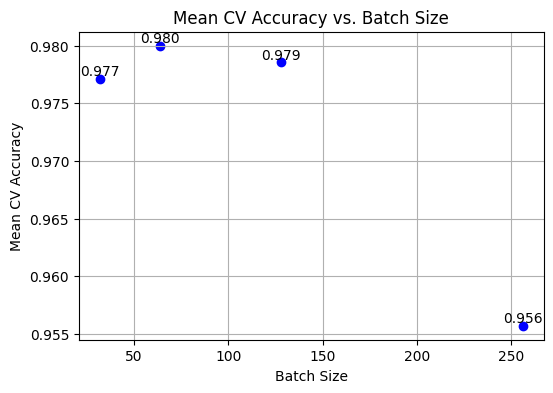

In [314]:
plt.figure(figsize=(6, 4))
plt.scatter(acc_dict.keys(), acc_dict.values(), color='blue')
for bs in acc_dict:
    plt.text(bs, acc_dict[bs], f"{acc_dict[bs]:.3f}", ha='center', va='bottom')
plt.title("Mean CV Accuracy vs. Batch Size")
plt.xlabel("Batch Size")
plt.ylabel("Mean CV Accuracy")
plt.grid(True)
plt.show()

4. Create a table of time taken to train the network on the last epoch against different batch sizes. 

In [317]:
print("\nTime taken for each batch size (seconds):\n")
print(f"{'Batch Size':<10} | {'Time (s)':<10}")
print("-" * 25)
for bs, t in time_dict.items():
    print(f"{bs:<10} | {t:.2f}")


Time taken for each batch size (seconds):

Batch Size | Time (s)  
-------------------------
32         | 0.97
64         | 0.63
128        | 0.46
256        | 0.38


5. Select the optimal batch size and state a reason for your selection.

Batch size 128 is the optimal setting. It provides a good balance between training speed (0.45 seconds) and high accuracy in the cross-validation results, making it both efficient and effective for the model.

Part A, Q3 (10 marks)
---
In this question, we will find the optimal number of hidden neurons for first hidden layer of the 4-layer network (3 hidden layers, output layer) designed in Q1 and Q2.

To reduce repeated code, you may need to import the network (MLP defined in QA1) from common_utils.py. You will not be repenalised for any error in QA1 here as the code in QA1 will not be remarked. The following code cell will not be marked.

In [319]:
from common_utils import MLPModel

> Plot the mean cross-validation accuracies on the final epoch for different numbers of hidden-layer neurons using a scatter plot. Limit the search space of the number of neurons to {64, 128, 256}. Continue using 5-fold cross validation on training dataset. 

1. Perform hyperparameter tuning for the different neurons with 5-fold cross validation.

In [321]:
def cross_val_score_for_hidden_dim(X, y, hidden_dim, n_splits=5, epochs=10, batch_size=128, lr=0.001):
    """
    Performs K-fold cross-validation for a given hidden_dim.
    Returns the average accuracy across folds.
    """
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    fold_accuracies = []

    for train_idx, val_idx in kf.split(X):
        # Split data for this fold
        X_train_fold, X_val_fold = X[train_idx], X[val_idx]
        y_train_fold, y_val_fold = y[train_idx], y[val_idx]

        # Scale data within this fold
        scaler = StandardScaler()
        X_train_fold = scaler.fit_transform(X_train_fold)
        X_val_fold   = scaler.transform(X_val_fold)

        # Convert to PyTorch tensors
        X_train_t = torch.tensor(X_train_fold, dtype=torch.float32)
        y_train_t = torch.tensor(y_train_fold, dtype=torch.float32)
        X_val_t   = torch.tensor(X_val_fold,   dtype=torch.float32)
        y_val_t   = torch.tensor(y_val_fold,   dtype=torch.float32)

        # Create DataLoaders
        train_dataset = TensorDataset(X_train_t, y_train_t)
        val_dataset   = TensorDataset(X_val_t,   y_val_t)
        train_loader  = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        val_loader    = DataLoader(val_dataset,   batch_size=batch_size, shuffle=False)

        # Initialize fresh model for each fold
        input_dim = X.shape[1]
        model = MLPModel(input_dim=input_dim, hidden_dim=hidden_dim)
        criterion = nn.BCELoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)

        # Train model
        for epoch in range(epochs):
            model.train()
            for Xb, yb in train_loader:
                optimizer.zero_grad()
                outputs = model(Xb).squeeze()
                loss = criterion(outputs, yb)
                loss.backward()
                optimizer.step()

        # Evaluate on validation fold
        model.eval()
        correct, total = 0, 0
        with torch.no_grad():
            for Xb_val, yb_val in val_loader:
                outputs_val = model(Xb_val).squeeze()
                preds = (outputs_val >= 0.5).float()
                correct += (preds == yb_val).sum().item()
                total   += yb_val.size(0)

        fold_acc = correct / total
        fold_accuracies.append(fold_acc)

    return np.mean(fold_accuracies)

hidden_dims = [64, 128, 256]
acc_dict_neurons = {}

for hd in hidden_dims:
    mean_acc = cross_val_score_for_hidden_dim(
        X_train_scaled,  
        y_train,
        hidden_dim=hd,
        n_splits=5,
        epochs=10,       
        batch_size=128,  
        lr=0.001
    )
    acc_dict_neurons[hd] = mean_acc
    print(f"Hidden Dim: {hd}, Mean CV Accuracy: {mean_acc:.4f}")

Hidden Dim: 64, Mean CV Accuracy: 0.9600
Hidden Dim: 128, Mean CV Accuracy: 0.9736
Hidden Dim: 256, Mean CV Accuracy: 0.9800


2. Plot the mean cross-validation accuracies on the final epoch for different numbers of hidden-layer neurons using a scatter plot. Limit the search space of the number of neurons to {64, 128, 256}.

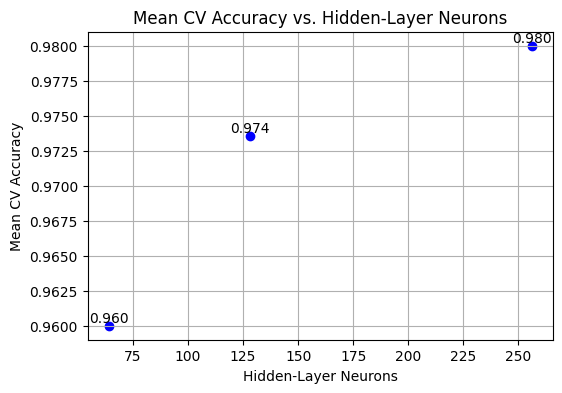

In [323]:
plt.figure(figsize=(6, 4))
plt.scatter(acc_dict_neurons.keys(), acc_dict_neurons.values(), color='blue')
for hd in acc_dict_neurons:
    plt.text(hd, acc_dict_neurons[hd], f"{acc_dict_neurons[hd]:.3f}", ha='center', va='bottom')
plt.title("Mean CV Accuracy vs. Hidden-Layer Neurons")
plt.xlabel("Hidden-Layer Neurons")
plt.ylabel("Mean CV Accuracy")
plt.grid(True)
plt.show()

> Select the optimal number of neurons for the hidden layer. State the rationale for your selection.

In [325]:
# Picking the hidden dimension with the highest mean CV accuracy
best_hidden_dim = max(acc_dict_neurons, key=acc_dict_neurons.get)
print(f"\nOptimal hidden dimension: {best_hidden_dim} neurons.")
print(f"Reason: It yields the highest cross-validation accuracy ({acc_dict_neurons[best_hidden_dim]:.4f}).")


Optimal hidden dimension: 256 neurons.
Reason: It yields the highest cross-validation accuracy (0.9800).


> Plot the train and test accuracies against training epochs with the optimal number of neurons using a line plot.
Note: use this optimal number of neurons for the rest of the experiments.

Epoch [1/100] Train Loss: 0.5062, Train Acc: 0.8207, Test Loss: 0.3445, Test Acc: 0.8567
Epoch [2/100] Train Loss: 0.2617, Train Acc: 0.8936, Test Loss: 0.2073, Test Acc: 0.9167
Epoch [3/100] Train Loss: 0.1548, Train Acc: 0.9386, Test Loss: 0.1749, Test Acc: 0.9350
Epoch [4/100] Train Loss: 0.1077, Train Acc: 0.9593, Test Loss: 0.1510, Test Acc: 0.9433
Epoch [5/100] Train Loss: 0.0684, Train Acc: 0.9786, Test Loss: 0.1195, Test Acc: 0.9600
Epoch [6/100] Train Loss: 0.0548, Train Acc: 0.9850, Test Loss: 0.1014, Test Acc: 0.9667
Epoch [7/100] Train Loss: 0.0383, Train Acc: 0.9864, Test Loss: 0.0987, Test Acc: 0.9700
Epoch [8/100] Train Loss: 0.0295, Train Acc: 0.9936, Test Loss: 0.0867, Test Acc: 0.9700
Epoch [9/100] Train Loss: 0.0223, Train Acc: 0.9943, Test Loss: 0.1063, Test Acc: 0.9650
Epoch [10/100] Train Loss: 0.0234, Train Acc: 0.9921, Test Loss: 0.1132, Test Acc: 0.9683
Epoch [11/100] Train Loss: 0.0127, Train Acc: 0.9964, Test Loss: 0.1277, Test Acc: 0.9667
Epoch [12/100] Trai

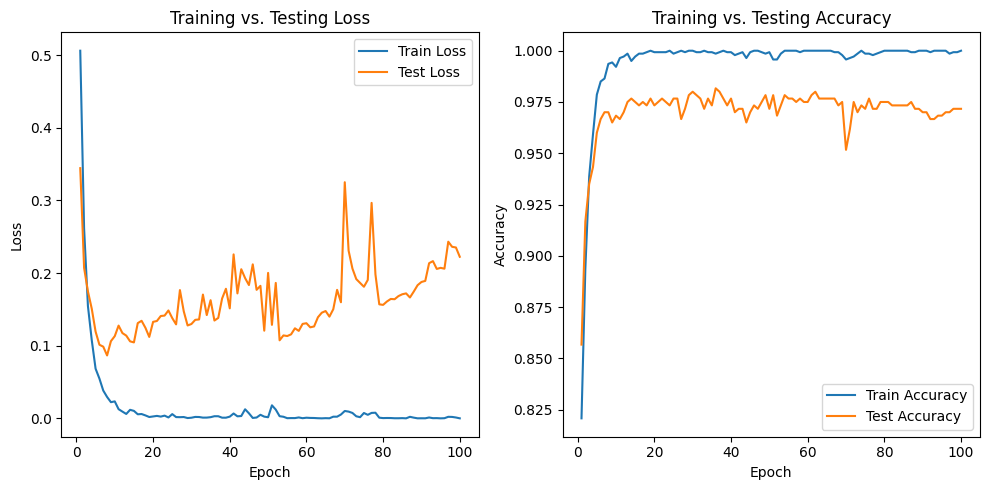

In [327]:
# Fit a final scaler on the entire training set
scaler_final = StandardScaler()
X_train_scaled_final = scaler_final.fit_transform(df_train)  
X_test_scaled_final  = scaler_final.transform(df_test)       

# Convert to PyTorch tensors
X_train_t = torch.tensor(X_train_scaled_final, dtype=torch.float32)
y_train_t = torch.tensor(y_train, dtype=torch.float32)
X_test_t  = torch.tensor(X_test_scaled_final,  dtype=torch.float32)
y_test_t  = torch.tensor(y_test,  dtype=torch.float32)

# Create DataLoaders
batch_size = 128
train_dataset = TensorDataset(X_train_t, y_train_t)
test_dataset  = TensorDataset(X_test_t,  y_test_t)
train_loader  = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader   = DataLoader(test_dataset,  batch_size=batch_size, shuffle=False)

# Initialize final model with best_hidden_dim
final_model = MLPModel(input_dim=X_train_scaled_final.shape[1], hidden_dim=best_hidden_dim)
criterion   = nn.BCELoss()
optimizer   = torch.optim.Adam(final_model.parameters(), lr=0.001)

num_epochs = 100  # 20 or 100
train_losses, test_losses = [], []
train_accs, test_accs = [], []

# Train the final model
for epoch in range(num_epochs):
    # --- Training ---
    final_model.train()
    running_loss, correct, total = 0.0, 0, 0
    for Xb, yb in train_loader:
        optimizer.zero_grad()
        outputs = final_model(Xb).squeeze()
        loss = criterion(outputs, yb)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * Xb.size(0)
        preds = (outputs >= 0.5).float()
        correct += (preds == yb).sum().item()
        total += yb.size(0)

    epoch_train_loss = running_loss / len(train_loader.dataset)
    epoch_train_acc  = correct / total

    # --- Testing ---
    final_model.eval()
    running_loss_test, correct_test, total_test = 0.0, 0, 0
    with torch.no_grad():
        for Xb_test, yb_test in test_loader:
            outputs_test = final_model(Xb_test).squeeze()
            loss_test = criterion(outputs_test, yb_test)
            running_loss_test += loss_test.item() * Xb_test.size(0)

            preds_test = (outputs_test >= 0.5).float()
            correct_test += (preds_test == yb_test).sum().item()
            total_test += yb_test.size(0)

    epoch_test_loss = running_loss_test / len(test_loader.dataset)
    epoch_test_acc  = correct_test / total_test

    train_losses.append(epoch_train_loss)
    test_losses.append(epoch_test_loss)
    train_accs.append(epoch_train_acc)
    test_accs.append(epoch_test_acc)

    print(f"Epoch [{epoch+1}/{num_epochs}] "
          f"Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_acc:.4f}, "
          f"Test Loss: {epoch_test_loss:.4f}, Test Acc: {epoch_test_acc:.4f}")

# Plot results
epochs_ran = range(1, num_epochs + 1)
plt.figure(figsize=(10,5))

# Loss plot
plt.subplot(1,2,1)
plt.plot(epochs_ran, train_losses, label='Train Loss')
plt.plot(epochs_ran, test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs. Testing Loss')
plt.legend()

# Accuracy plot
plt.subplot(1,2,2)
plt.plot(epochs_ran, train_accs, label='Train Accuracy')
plt.plot(epochs_ran, test_accs, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training vs. Testing Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

Part A, Q4 (10 marks)
---
In this section, we will understand the utility of such a neural network for a test audio. 

Do a model prediction on the sample test audio and obtain the predicted label using a threshold of 0.5. The model used is the optimized pretrained model using the selected optimal batch size and optimal number of neurons. 
Find the most important features on the model prediction for the test sample using SHAP. Plot the local feature importance with a force plot and explain your observations.  (Refer to the documentation and these three useful references:
https://christophm.github.io/interpretable-ml-book/shap.html#examples-5, 
https://towardsdatascience.com/deep-learning-model-interpretation-using-shap-a21786e91d16,  
https://medium.com/mlearning-ai/shap-force-plots-for-classification-d30be430e195) 

To reduce repeated code, you may need to import the network (MLP defined in QA1) from **common_utils.py**. You will not be repenalised for any error in QA1 here as the code in QA1 will not be remarked. The following code cell will not be marked.

In [329]:
from common_utils import MLPModel, extract_features

> Install and import shap

In [199]:
import shap

> Preprocess 'audio_test.wav' using the function 'extract_features' in common_utils.py. Please make sure the features are stored in a pandas dataframe, using variable name 'df', and fill the size of 'df' in 'size_row' and 'size_column'.

In [357]:
import IPython
IPython.display.Audio("./audio_test.wav")

df = extract_features("./audio_test.wav")
size_row, size_column = df.shape

print(f"DataFrame shape: {size_row} row(s) x {size_column} column(s)")
df.head()

DataFrame shape: 1 row(s) x 58 column(s)


,filename,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,rolloff_mean,...,mfcc16_mean,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var
0,./audio_test.wav,0.431877,0.080057,0.056604,0.000293,1191.619716,40957.603068,1726.917471,38831.324373,2794.225223,...,-3.746181,56.647854,-6.391425,37.167595,-2.303412,43.675926,-8.247708,30.50214,-13.786491,46.941544


> Do a model prediction on the sample test audio and obtain the predicted label using a threshold of 0.5. The model used is the optimized pretrained model using the selected optimal batch size and optimal number of neurons. 

 1.  Preprocess to obtain the test data, save the test data as numpy array, print the shape of the test data.

In [359]:
df_test_sample_feat = df.drop(["filename", "label"], axis=1, errors="ignore")
df_test_sample_feat = df.reindex(columns=train_columns)

X_test_sample_scaled = scaler_final.transform(df_test_sample_feat)

2. Do a model prediction on the sample test audio and obtain the predicted label using a threshold of 0.5. The model used is the optimized pretrained model using the selected optimal batch size and optimal number of neurons. Note: Please define the variable of your final predicted label as 'pred_label'.

In [363]:
# Convert the scaled test sample into a PyTorch tensor
test_sample_tensor = torch.tensor(X_test_sample_scaled, dtype=torch.float32)

# Make the prediction
final_model.eval()

with torch.no_grad():
    output = final_model(test_sample_tensor).squeeze()
    pred_prob = output.item()
    pred_label = "metal" if pred_prob >= 0.5 else "blues"

print(f"Predicted probability of 'metal': {pred_prob:.4f}")
print(f"Predicted label: {pred_label}")

Predicted probability of 'metal': 0.0003
Predicted label: blues


> Find the most important features on the model prediction for your test sample using SHAP. Create an instance of the DeepSHAP which is called DeepExplainer using traianing dataset: https://shap-lrjball.readthedocs.io/en/latest/generated/shap.DeepExplainer.html.

Plot the local feature importance with a force plot and explain your observations.  (Refer to the documentation and these three useful references:
https://christophm.github.io/interpretable-ml-book/shap.html#examples-5, 
https://towardsdatascience.com/deep-learning-model-interpretation-using-shap-a21786e91d16,  
https://medium.com/mlearning-ai/shap-force-plots-for-classification-d30be430e195) 

In [402]:
'''
Fit the explainer on a subset of the data (you can try all but then gets slower)
Return approximate SHAP values for the model applied to the data given by X.
Plot the local feature importance with a force plot and explain your observations.
'''
# Provide a small background set from training data
background_data = torch.tensor(X_train_scaled[:100], dtype=torch.float32)

# Create the DeepExplainer
explainer = shap.DeepExplainer(model, background_data)

# Compute SHAP values for the single test sample
shap_values = explainer.shap_values(test_sample_tensor)

# Initialize shap's JS for interactive visuals 
shap.initjs()

# shap_values[0] is shape (57, 1). Flatten it to shape (57,).
shap_values_single = shap_values[0].reshape(-1)

# Now shap_values_single is (57,)
shap.force_plot(
    explainer.expected_value[0],
    shap_values_single,
    df_test_sample_feat.columns
)


#### Comments:
The most important features were perceptr_var, mfcc20_mean, and mfcc7_mean, as shown by the largest red bars on the force plot. Musically, these relate to rhythmic/percussive variability (perceptr_var) and distinct upper-range timbral characteristics (MFCCs). Although these red bars tried to push the score high (i.e. toward metal), the largest blue bars—such as mfcc3_mean, spectral_centroid_mean, and rolloff_mean—overshadowed them and lowered the score. This reflects how lower-frequency content (spectral centroid, rolloff) and certain MFCC patterns are more typical of blues, ultimately leading the model to classify the track closer to blues.